In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


# import Pkg; Pkg.add("@time")
Pkg.add("FastGaussQuadrature")

In [ ]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

In [ ]:
Pkg.add("PyPlot")

In [1]:
using Plots

using StaticArrays
import LinearAlgebra
import FastGaussQuadrature

push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4
    
    KBLZ = 1.3807E-16 

    HPL = 6.6261E-27 
    HPLB= 1.0546E-27

    RGAS = 8.31E7; 
    PC = 3.085678E18;

    MP = 1.672661E-24;
    ME = 9.1094E-28

    QE=4.8032E-10

    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    tst=1

end


#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceRadGrid

        
# gaussnodes -   Gauss-Legendre nodes
# gaussweights - Gauss-Legendre weights



using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    @show const BIGNUMBER = 1.0E50



    @kwdef struct SGridPar
        

        Nactive = 10;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -1.
        x1e = 1.
    
        x2s = -2.
        x2e = 2.

        x3s = -3.
        x3e = 3.
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 15 ; # ν - N bins 
    
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta    
        N_fre_ang = Nfreq*Nang  
            
    
    end




# ------ Init Space and Radiation grids --------------------------------

sg= SGridPar()
rad = RGridPar()


# radiaion matter grid is offset from the space grid boundaries
roffst = 2

is_r = sg.is + roffst
ie_r = sg.ie - roffst 

js_r = sg.js + roffst
je_r = sg.je - roffst 

ks_r = sg.ks + roffst
ke_r = sg.ke - roffst 


# μ = zeros(Float64, rad.NumTheta)     
# @show gaussnodes, gaussweights = FastGaussQuadrature.gausslegendre(rad.NumTheta);
# @show μ .= gaussnodes

# @time nodes, weights = gausslegendre( 100000 );
# 0.007890 seconds (19 allocations: 2.671 MB)




θ = range(0, pi; length = rad.NumTheta)
ϕ   = range(0, 2pi-pi/rad.NumPhi; length = rad.NumPhi)


# ----------------------------------------------------------------------

#                                Grid

x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)

# ----------------------------------------------------------------------
#                               Gas   



den = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
Tgas = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
OpaCon = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot)

const Tsc=7500.0  #a reference gas T
const Dsc=10.0  #a reference gas ρ


# ----------------------------------------------------------------------
#                             Radiation
νRange = Array{Float64}(undef, rad.Nfreq) 

IrPos = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, forward
IrNeg = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, backward
Jν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation mean intensity, J
Sν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation mean intensity, S_nu

ν_h1 = 3.29e15

Nlines = 1
A_ion = 1 # ion atomic weight

νLines = zeros(Float64,Nlines) .= 2.47e15

# ν_min = 0.1*3.5e15     
# ν_max = 10*νLines[end]     

const NGaussNodes = 10

# ----------------------------------------------------------------------

function MakeXYZstagGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
    
    
end

mutable struct LongRay
    numOfElm::Int32    
    id::Int32 #id in dir array
    ijkOfCellCrossed :: Matrix{Int32}        
    xyzPos :: Matrix{Float64}
    orig::Int32 #the origin of the ray, as lin index
end


mutable struct LongRay1  #long ray without a dir

    numOfElm::Int32    
    
#     hed :: Vector{Int32}    
#     dir :: Vector{Float64} 
    
    ijkOfCellCrossed :: Matrix{Int32}        
    xyzPos :: Matrix{Float64}
end


mutable struct RayPair
    
    hed ::Vector{Int32}    
    
    dir::Vector{Float64}    
    
    ray_f:: LongRay1 #forward    
    ray_b:: LongRay1 #backward    
    
end



MakeXYZstagGrid(x1,x2,x3,x1b,x2b,x3b,sg)
@show x3
@show x3b

    
NumElemInRayMax = 2*max(sg.Nxtot,sg.Nytot,sg.Nztot)
    
arrOfLongRay = Array{LongRay, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
# @time rayPairArr = Array{RayPair, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
     


function xyzToijk(xin::Float64, yin::Float64, zin::Float64)
    i = argmin( abs.(x1 .-xin )); 
    j = argmin(abs.(x2.-yin)); 
    k = argmin(abs.(x3.-zin))    
    return(i,j,k)
end

# argmin(νRange,1.0E14)


const BIGNUMBER = 1.0e50 = 1.0e50
x3 = [-3.6666666666666665, -3.0, -2.3333333333333335, -1.6666666666666667, -1.0, -0.3333333333333333, 0.3333333333333333, 1.0, 1.6666666666666667, 2.3333333333333335, 3.0, 3.6666666666666665]
x3b = [-4.0, -3.333333333333333, -2.666666666666667, -2.0, -1.3333333333333335, -0.6666666666666666, 0.0, 0.6666666666666667, 1.3333333333333335, 2.0, 2.666666666666667, 3.333333333333333]


xyzToijk (generic function with 1 method)

### 

In [65]:
function DefineMatter(sg::SGridPar, rad::RGridPar)    
    Tgas .= Tsc     
    den .=  Dsc  # cm^-3 of nH + nH0    
#     den .= 1.0E18                
end

function Bν(ν::Float64,T::Float64)
    
  return ( 2.0*PhysConst.HPL* ν^3/(PhysConst.CL^2)/
        (exp(PhysConst.HPL*ν/PhysConst.KBLZ/T)-1.) )
    
end
# SPECTRUM


function DefineRadiation(ν_min, ν_max, wtodo, rad::RGridPar)
    
    if wtodo=="BB"              
        ν_1 = ν_min
        ν_2 = ν_max     
        
        @show νRange  .= range(ν_1,ν_2, length=rad.Nfreq)        

        is = is_r; ie = ie_r    
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         

#         UpdateOpacGrid(sg)
        
        for k=sg.ks:sg.ke
            for j=sg.js:sg.je        
                for i=sg.is:sg.ie                   
                  for f=1:rad.Nfreq
                        
                        νi = νRange[f]                        
                        
                        Jν[f,i,j,k] = Bν(νi,Tgas[i,j,k])
                        Sν[f,i,j,k] = Bν(νi,Tgas[i,j,k])
                        
                        
                   end
                end
            end
        end
                                                        

    else        
        error("undefined in DefineSpectrum")    
    end 
    
end

function LineDoppWidth(ν0::Float64, i::Int64, j::Int64, k::Int64 )
    @show Te::Float64 = Tgas[i,j,k]
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL    
    
end

function LineDoppWidth(ν0::Float64, Te::Float64)
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL        
end



# function LineProfDop(ν::Float64, ν0::Float64, i::Int64,j::Int64,k::Int64)    
#     Δν::Float64 = LineDoppWidth(ν0,i,j,k)    
#     x::Float64 = (ν-ν0)/Δν    
#     ϕ::Float64 = exp(-x^2)/sqrt(π)
# end


function LineProfDopp(x::Float64)    
    ϕ::Float64 = exp(-x^2)/sqrt(π)
end


@show dν_D = LineDoppWidth(νLines[1], is_r, ks_r, ks_r)

# LineProfDop(νLines[1], is_r, ks_r, ks_r)
# # integrates f(x) = x^2 from -1 to 1
# @time dot( weights, nodes.^2 )


# needed to integrate over the spec. l. profile



ξi, wi = FastGaussQuadrature.gausshermite(NGaussHermNodes);
@show ξi

@show LinearAlgebra.dot([1.0 for ξl in ξi], wi)/√π


DefineMatter(sg,rad)
DefineRadiation("BB", rad)



Te::Float64 = Tgas[i, j, k] = 7500.0
dν_D = LineDoppWidth(νLines[1], is_r, ks_r, ks_r) = 9.168746150559534e10
ξi = [-3.4361591188377374, -2.5327316742327897, -1.7566836492998803, -1.0366108297895167, -0.34290132722370714, 0.34290132722370714, 1.0366108297895167, 1.7566836492998803, 2.5327316742327897, 3.4361591188377374]
LinearAlgebra.dot([1.0 for ξl = ξi], wi) / √π = 1.0000000000000002
νRange .= range(ν_1, ν_2, length = rad.Nfreq) = [3.5e14, 2.0892857142857142e15, 3.8285714285714285e15, 5.567857142857143e15, 7.307142857142857e15, 9.046428571428572e15, 1.0785714285714286e16, 1.2525e16, 1.4264285714285714e16, 1.6003571428571428e16, 1.7742857142857142e16, 1.9482142857142856e16, 2.1221428571428572e16, 2.2960714285714284e16, 2.47e16]


In [37]:
plot(νRange, map(u->Bν(u, Tgas[1,1,1]), νRange), xaxis=:log10, yaxis=:log10)

dν_D = LineDoppWidth(νLines[1], is_r, ks_r, ks_r)

nuRangeNonD = (νRange .- νLines[1])/(dν_D*10)


map(x->LineProfDop(x), nuRangeNonD)

# plot(x, map((x)->LineProfDop(x), νRange), xaxis=:log10, yaxis=:log10) 

# LineProfDopp()



Te::Float64 = Tgas[i, j, k] = 7500.0


15-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [1]:
# import PhysConst, only:HPL








function testBν()
    
    Trange = range(10.0^4, 10.0^5, length= 3)
    
    T=Tsc
    y =[Bν(nu,T) for nu in νRange]

#     @show -Bν(ν, T)
    
    plot(νRange, y, xaxis=:log, yaxis=:log)

#     for T in Trange
#     #     @show T
#         y =[Bν(nu,T) for nu in νRange]

#         plot!(νRange, y, xaxis=:log, yaxis=:log)


#     end

#     current()

end

DefinePhysModel(sg, rad);

@show Bν(1.0E17, 10.0E5)





UndefVarError: UndefVarError: DefinePhysModel not defined

In [39]:
function CrossSectionPhotoIonization(ν::Float64) #[cm^2]
    #photo-ionization cross-section

    Z=1.0    
    
    ν0 = 3.29e15
    
    if ν < ν0
        return(0.0)
    else
        
        ν1 = Z^2 * ν0     
        
        A0 = 6.3E-18
    
        y = ν/ν1
        
        ϵ = sqrt(y-1.0) 
    
        f1 = 1/(1.0 - exp(-2.0*pi/ϵ))
        
        e1 = exp(4.0 - 4.0*atan(ϵ)/ϵ)
           
        a = A0/Z^2*y^(-4)*e1*f1
    
        return(a)        
    end
    
end


function RecombinationCoefficient(ν::Float64, i::Int64, j::Int64, k::Int64)
     
    @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
    
    @show Te = Tgas[i,j,k]
    # α1 = 8*Pi*(ν/PhysConst.CL)^2*
    
    α1::Float64 = 10.0^(-14)   
    
    a1ν::Float64 = CrossSectionPhotoIonization(ν)
    
#     @show exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))
    
    α1 = 8π*ν^2/PhysConst.CL^2*(PhysConst.HPL^2/(2π*PhysConst.ME*PhysConst.KBLZ * Te))^(3/2)*a1ν * exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))

    @show  a1ν α1 a1ν
    
    return(α1)
       
end

function OpacityRecombination(ν::Float64, i::Int64, j::Int64, k::Int64) #[cm^-1]
    
# α1 = 8*Pi*(ν/PhysConst.CL)^2*(PhysConst.HPL^2/(2Pi*PhysConst.M))
    
   @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
    Te = Tgas[i,j,k]
    Σα = RecombinationCoeffficient(ν,i,j,k)
    
    κ_h = n_h * Σα
    
    return(κ_h)
           
end

function EmissivityCoeffficient(ν::Float64, i::Int64, j::Int64, k::Int64)
   #recombintaion emissivity 
#     Σα
#     n_e * n_io

    n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
    Te = Tgas[i,j,k]

    
    RecombCoef = RecombinationCoeffficient(ν,i,j,k)
    jν = RecombCoef * /(4π)
    
    return(jν)
    
end



function IonizationFromPhotoEquilibriuum(ν::Float64, i::Int64, j::Int64, k::Int64)

    Σα = RecombinationCoeffficient(ν, i, j, j)
    n_h = den[i,j,k]
    
    @show IntJ = Jν[1]*(ν_max-ν_min) #1 approx 
    
    ξ_h = n_h * Σα/IntJ
        
end    


function OpacityCoef(lineId::Int64, i::Int64, j::Int64, k::Int64)
    
    return 10
    
end

    
# begin
#  ν_1 = 0.5*3.5e15
#  ν_2 = 10*ν_1
#  nuvec = range(ν_1,ν_2, length=100);        
#  y =[CrossSecPhotIoniz(ν) for ν in nuvec];
#  y .= y/10^-18
# end
# plot(nuvec, y)

@show Jν[:, is_r, js_r, ks_r]

@show ν_h1 nu = νRange[2]

@show CrossSectionPhotoIonization(nu)

@show RecombinationCoeffficient(1.0,3,3,3)

IonizationFromPhotoEquilibriuum(nu, 3, 3, 3)



Jν[:, is_r, js_r, ks_r] = [7.535693330624674e-5, 2.1018758092133062e-7, 1.8981224759498586e-11, 8.567997322684191e-16, 2.842228340314594e-20, 7.914960424105614e-25, 1.9686345737498092e-29, 4.5243133660653165e-34, 9.807778802633169e-39, 2.032695911016391e-43, 4.065307902125504e-48, 7.898307690434309e-53, 1.4981276749670655e-57, 2.7847246720172916e-62, 5.087659526274645e-67]
ν_h1 = 3.29e15
nu = νRange[2] = 2.0892857142857142e15
CrossSectionPhotoIonization(nu) = 0.0


UndefVarError: UndefVarError: RecombinationCoeffficient not defined

In [ ]:
pi

dir = norm[rayid, :] = [-0.6300367553350504, -0.32101976096010315, 0.7071067811865476]
ip = ijk_pos_s[IX] = 6


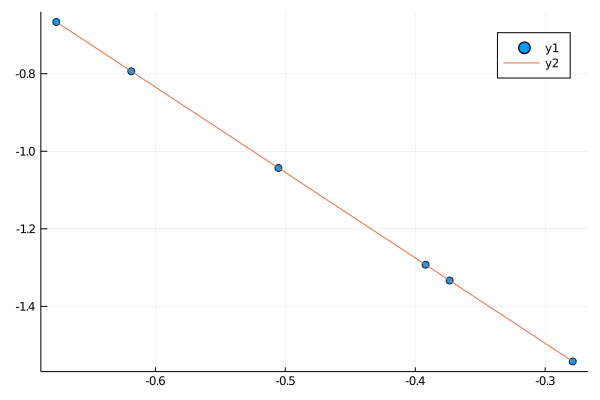

ray.xyzPos[ax2, :] = [-0.2788361610549365, -0.3735523888020711, -0.39206403872036516, -0.5052919163857938, -0.6185197940512225, -0.6762127219617691, 2.351143999e-314, 2.339333474e-314, 2.3510745766e-314, 2.3512231283e-314, 2.2938304866e-314, 2.2387763644e-314, 2.2938304866e-314, 2.238776554e-314, 2.3510747663e-314, 2.3512990326e-314, 2.3511479355e-314, 2.3393348417e-314, 2.3513022737e-314, 2.351148062e-314, 2.339335561e-314, 2.3514344936e-314, 2.3514355686e-314, 2.3511482043e-314]
ray.numOfElm = 6
y1 = ray.xyzPos[ax2, 1:ray.numOfElm] = [-1.54196375137396, -1.3333333333333335, -1.2925579207885463, -1.0431520902031326, -0.7937462596177192, -0.6666666666666666]
x1 = ray.xyzPos[ax1, 1:ray.numOfElm] = [-0.2788361610549365, -0.3735523888020711, -0.39206403872036516, -0.5052919163857938, -0.6185197940512225, -0.6762127219617691]


In [40]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)
distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()
ijk_pos_s = Array{Int32,1}(undef,3)
ijk_pos = Array{Int64}(undef,3)
ijk_max = Array{Int64}(undef,3)
ijk_min = Array{Int64}(undef,3)
ijk_tmp = Array{Int64}(undef,3)

ijk_max .= [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min .= [ sg.is, sg.js, sg.ks ] #min index
ijk_tmp .= [0, 0, 0]

xbi_zip= [x1b, x2b, x3b]

# display(xbi_zip)

function FirstTimeTraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay, sg::SGridPar)

    
    dist = 0.0   
    distToNextCell .= BIGNUMBER
    rayOne.numOfElm = 0.0
    
    xn .= x3c
    
#     println("start: ", xn ,"\n")
        
    itermax = 2 * sg.Nx

    for iter in 1:itermax #max length, may be smaller than actual

#      println("*************************")
#      @show xn iter
#      @show ijk_pos

        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms

            xc = x3c[n_it] 

             if iter > 1 

                ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                itmp = ijk_tmp[n_it]
             
                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])
                    
                elseif norm_i <0               
                    
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else
                    
                    itmp = ijk_pos[n_it]            
                    
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end
                # @show itmp

             if norm_i != 0                      
                               
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])

             else
                distToNextCell[n_it] = BIGNUMBER
             end


#         println("iter= ",iter," xn=",  xn, " ===> ", "n_it = ",n_it," \n ",
#                 "distToNextCell[",n_it,"]=",distToNextCell[n_it])

            end #for loop over possible directions
                                
        posIndxToUpdate = argmin( distToNextCell )

        dist = distToNextCell[posIndxToUpdate]


        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    

        xn .= x3c .+ dir*dist   
        
#         xn[posIndxToUpdate] = xbi_zip[posIndxToUpdate][ijk_tmp[posIndxToUpdate]]        
#         println(posIndxToUpdate, "   Corrected: ", xn) 
#         @show dir
#         @show posIndxToUpdate ijk_pos ijk_tmp                
#         println("xprev = ", x3c,   " ", "xaft= ", xn, "\n")
        
#         @show posIndxToUpdate dist

        
        x3c .= xn
        
        if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || 
            
            ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || 

            ijk_pos[posIndxToUpdate] == 1 ||             
            
            xn[1] <= x1b[sg.is] || xn[1] >= x1b[sg.ie] ||
            xn[2] <= x2b[sg.js] || xn[2] >= x2b[sg.je] ||
            xn[3] <= x3b[sg.ks] || xn[3] >= x3b[sg.ke] ||                        
            iter > 100 
                        
#             @show ijk_pos
#             println("quit..")
            break; 
        end      

        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

        if iter>1 && LinearAlgebra.norm(rayOne.xyzPos[:,iter]-rayOne.xyzPos[:,iter-1])<1E-10
            @show iter, rayOne.ijkOfCellCrossed[:,iter], rayOne.ijkOfCellCrossed[:,iter-1]
            @show dir            
            println( "!!!!!!!!!!!!  distance is very small  !!!!!!! \n")
        error( "error! ")            
        end                                
#         println("iter=", iter,"  ", "xn= ", xn)


    end #over ray

end # FirstTimeTraceGridCalcOneLongRay



function InitRayDirections(rad::RGridPar, sg::SGridPar)
            
    norm = zeros(Float64, rad.Nang, 3);
    
    m=1
    for (i,ph_i) in enumerate(ϕ)
        for (j,th_j) in enumerate(θ)
            
            μj = cos.(th_j)
            sinth_j = sqrt(1-μj^2)
            
            norm[m, IX] = sinth_j *sin(ph_i)
            norm[m, IY] = sinth_j *cos(ph_i)                 
            norm[m, IZ] = μj
                        
        m+=1;            
        end
    end

    return(norm)
end

norm = InitRayDirections(rad,sg)

# *****************************************************************
function PlotRay(ray::LongRay, ax1, ax2)

    
#     @show r0 = [x1[ic],x2[jc],x3[kc]]
#     m = 1
#     @show dir = norm[m,:]
#     ray = arrOfLongRay[m,ic,jc,kc]
#     for i in 1:ray.numOfElm
#         r = ray.xyzPos[:,i]
#     end

    @show y1 = ray.xyzPos[ax2,1:ray.numOfElm]
    @show x1 = ray.xyzPos[ax1,1:ray.numOfElm]
    
    p1 = plot(x1, y1,  seriestype = :scatter)
    p2 = plot!(p1, x1, y1)
        
    display(p2)

    
end 

function testFirstTimeTraceGridOverOneLongRay(rad::RGridPar, sg::SGridPar, swch)
    rayid = rand(1:rad.Nang)
    

    @show dir = norm[rayid,:]
    posInRay = 1 #
    
    if swch=="LongRay"
        testRay = LongRay(NumElemInRayMax, rayid,          
            Array{Int32}(undef,3,NumElemInRayMax),
            Array{Float64}(undef,3,NumElemInRayMax), posInRay )       
    else
        error("swch is not supported")
    end

    
    numTests=1
    for n = 1:numTests
        println( " test :", n )
        
        ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))]; 

        ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
        
        ijk_pos .= ijk_pos_s

        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        xyz_s = [ x1[ip], x2[jp], x3[kp] ]


        FirstTimeTraceGridOverOneLongRay(dir, testRay, sg)     
        
      
        
        rprev= zeros(Float64,3)
        
#         @show testRay.numOfElm
        
        if testRay.numOfElm > 0
            rprev = xyz_s
            for i=1:testRay.numOfElm
                  
                ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

                rprev .= testRay.xyzPos[:,i]
                
#                 @show i,ds
            end
            
                   
            xyz_e = testRay.xyzPos[:,testRay.numOfElm]                
            dist = LinearAlgebra.norm( xyz_e .- xyz_s)     


            xyz_0e = xyz_s + dir*dist

            Δ = LinearAlgebra.norm( xyz_e[:].-xyz_0e[:])/
                    LinearAlgebra.norm( xyz_0e[:])


            println("|| rend - rs ||/||rs|| = ",  Δ)    
            if Δ <= 1e-5
                println(" Test Passed ! ")    
            else
                println("𝐧 = ",  dir)                
                println(" xyz_e= ",  xyz_e)                
                println(" xyz_s= ",  xyz_s)                
                println(" xyz_0e= ",  xyz_0e)                    
                println(" dist=", dist)      
                error("Test Failed !")
            end

            
        end
            

        
    end
end

function test2(rad, sg)
    rayid = 2
    rayid = rand(1:rad.Nang)
    posInRay = 1 #
    x0=0. 
    y0=0. 
    z0=-2.
    
    @show dir = norm[rayid,:]

    ax1= 1
    ax2 = 2
    ax3 = 3
    
        
    ray = LongRay(NumElemInRayMax, rayid,          
            Array{Int32}(undef,3,NumElemInRayMax), Array{Float64}(undef,3,NumElemInRayMax),posInRay )       

    
    ic,jc,kc=xyzToijk(x0, y0, z0)                    
    ijk_pos .= ijk_pos_s.=[ic,jc,kc]

    
    @show  ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
    
    
    x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        
    xyz_s = [ x1[ip], x2[jp], x3[kp] ]

    FirstTimeTraceGridOverOneLongRay(dir, ray, sg)     

    
    @show ray.xyzPos[ax2,:] ray.numOfElm
  
    PlotRay(ray, ax2, ax3)
    
end



# testFirstTimeTraceGridOverOneLongRay(rad, sg, "LongRay")

test2(rad, sg)


In [41]:


# **************** Trace grid with long rays  ****************** #
    
println("1st time trace grid with long rays, perfom allcoations etc ..")

function TraceGridAllocRayArr(rad::RGridPar, sg::SGridPar, swch)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)

    x3c_head=Array{Float64}(undef,3)
    ijk_pos_head =Array{Int32}(undef,3)
    
    Nr=NumElemInRayMax
    posInRay =1 
    
    testRay_f = LongRay(Nr,1, Array{Int32}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       
    testRay_b = LongRay(Nr,1, Array{Int32}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       

    
    
    if swch=="All"
        is = is_r; ie = ie_r
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         
    elseif swch=="OneCell"
        is=ie=ijk_pos_s[IX]; js=je=ijk_pos_s[IY]; ks=ke=ijk_pos_s[IZ]
    else 
        error("Unknown case in TraceGridAllocRayArr")        
    end
         


    for k=ks:ke
        println("k=",k, " of ",ks,":",ke)
        
        for j=js:je        

            for i=is:ie    
        


                if swch=="All"
                    ijk_pos_s.= [i,j,k]   
                end   
                
                ijk_pos_head .= ijk_pos_s #remember the origin
                
                for m=1:rad.Nang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot

#      @show m " new angle  ****************"
                    dirf .= norm[m,:]
                    dirb .= -norm[m,:]

                    ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
           
                    ijk_pos .= ijk_pos_s        
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
                    
                    x3c_head .= x3c #origin 
                    
# @show "forw"
                    FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg)        
                    
                    

                   ijk_pos .= ijk_pos_s           
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
# @show "back"
                    FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg)                                            
        
               

#              @show  ijk_pos dirf
                    
                    # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]

                    Ntot = testRay_f.numOfElm + testRay_b.numOfElm +1
                    
                    origCellId = testRay_b.numOfElm + 1 #knowing origCellId one can calc the origin cell
                    
                    arrOfLongRay[m,ip,jp,kp] = LongRay(Ntot, m,            
                        Array{Int32}(undef,3,Ntot), Array{Float64}(undef,3,Ntot), origCellId)

                    arrOfLongRay[m,ip,jp,kp].id = m


                    for iter = 1:testRay_b.numOfElm
                        ib = testRay_b.numOfElm - iter+1                         
                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_b.ijkOfCellCrossed[:,ib]                                    
                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_b.xyzPos[:,ib]                                    
                   end                       

                   arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,origCellId] .= ijk_pos_head
                   arrOfLongRay[m,ip,jp,kp].xyzPos[:,origCellId] .= x3c_head
                    
                    for iter = testRay_b.numOfElm + 2 : Ntot

                        i = iter - testRay_b.numOfElm -1 # 1, 2,3, ... (testRay_f.numOfElm + testRay_b.numOfElm)

                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_f.ijkOfCellCrossed[:,i]

                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_f.xyzPos[:,i]

                    end


              
                end 
            end
        end
    end
   
    
end

# function distAlongRay
#         if testRay.numOfElm > 0
#             rprev = xyz_s
#             for i=1:testRay.numOfElm
#                   ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

#                 rprev .= testRay.xyzPos[:,i]
                
# #                 @show i,ds
#             end
# end

function testTraceGridAllocRayArr(rad, sg)            

    
#     ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
#     ijk_pos .= ijk_pos_s             
#    @show  ijk_pos_s

    
#      TraceGridAllocRayArr(rad, sg, "OneCell") #"OneCell"        
#      @show ray =  arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]             
     println(" ************************************ ")     
    
      TraceGridAllocRayArr(rad, sg, "All")
    
      @show is = is_r; 
      @show ie = ie_r
      js = js_r; je = je_r 
      ks = ks_r; ke = ke_r  
    
    @show ray =  arrOfLongRay[rand(1:rad.Nang),rand(is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ] 


    println(" ************************************ ")     
    
    
#      PlotRay(ray, ax1, ax2)

end


testTraceGridAllocRayArr(rad, sg)        





# **************************************************************#    

1st time trace grid with long rays, perfom allcoations etc ..
 ************************************ 
k=4 of 4:9
k=5 of 4:9
k=6 of 4:9
k=7 of 4:9
k=8 of 4:9
k=9 of 4:9
is = is_r = 4
ie = ie_r = 9
ray = arrOfLongRay[rand(1:rad.Nang), rand(is_r:ie_r), rand(js_r:je_r), rand(ks_r:ke_r)] = LongRay(9, 20, Int32[9 9 9 9 9 9 9 9 9; 9 9 9 9 9 9 9 9 9; 10 9 9 8 7 6 5 4 3], [0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556 0.5555555555555556; 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112 1.1111111111111112; 2.0 1.6666666666666667 1.3333333333333335 0.6666666666666667 0.0 -0.6666666666666666 -1.3333333333333335 -2.0 -2.666666666666667], 2)
 ************************************ 


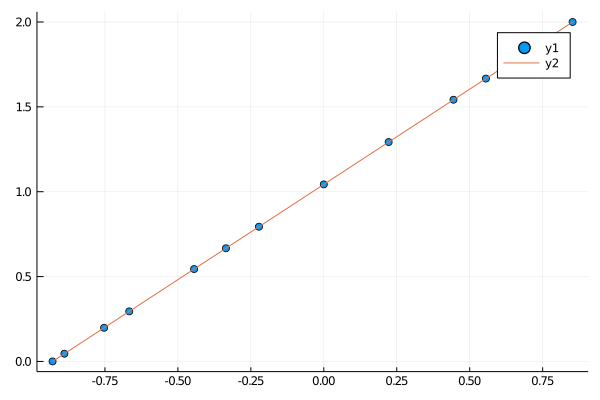

dir = norm[rayid, :] = [-0.6300367553350504, -0.3210197609601032, -0.7071067811865475]
ray.xyzPos[3, :] = [2.0, 1.7913695819593736, 1.6666666666666667, 1.54196375137396, 1.2925579207885465, 1.043152090203133, 0.7937462596177196, 0.6666666666666667, 0.5443404290323061, 0.2949345984468924, 0.19820715694315577, 0.04552876786147897, 0.0]
y1 = ray.xyzPos[ax2, 1:ray.numOfElm] = [2.0, 1.7913695819593736, 1.6666666666666667, 1.54196375137396, 1.2925579207885465, 1.043152090203133, 0.7937462596177196, 0.6666666666666667, 0.5443404290323061, 0.2949345984468924, 0.19820715694315577, 0.04552876786147897, 0.0]
x1 = ray.xyzPos[ax1, 1:ray.numOfElm] = [0.8525577302850115, 0.6666666666666667, 0.5555555555555556, 0.4444444444444444, 0.2222222222222222, 0.0, -0.2222222222222222, -0.33545096863281243, -0.4444444444444444, -0.6666666666666667, -0.7528514481145447, -0.8888888888888888, -0.9294553180917243]


In [96]:
function test3()
    rayid = rand(1:rad.Nang)

    x0=0. 
    y0=0. 
    z0=0.
      
    ax1= 1
    ax2 = 2
    ax3 = 3
    
    @show dir = norm[rayid,:]
    
    ic,jc,kc = xyzToijk(x0, y0, z0)                    


    ray =  arrOfLongRay[rayid, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
    
    @show ray.xyzPos[3,:]
    
    PlotRay(ray, ax1, ax3)
    
end
test3()

<h1>
<b>
Numerical
</b>
</h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  


<b> Matrix  </b> eq: 
$$
-A_i u_{i-1} + B_i u_{i} -C_i u_{i+1} = S_i
$$

Coefficients have a slightly different form compared to <b>RH91</b> for a slightly better representation of 
the numerical derivative on a staggered grid. The source term allows for implicit contribution from the $b_m u_m$ from $S$. 
 
 $$
 y_i \left(-b_m
    +\frac{p}{\delta \tau _i}
    \left(\frac{1}{\delta \tau _{i+\frac{1}{2}}}+\frac{1}{\delta \tau
   _{i-\frac{1}{2}}}\right)
   +1\right)
   -\frac{p y_{i-1}}{\delta \tau _{i-\frac{1}{2}} \delta \tau _i}
   -\frac{p y_{i+1}}{\delta \tau _i \delta \tau _{i+\frac{1}{2}}}-S_i-S_\beta=0
 $$

Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
 
 $$
 v(\tau=0)=u(\tau=0)\mbox{,}
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$


 $$
    i=1:\qquad y_1 \left(-\frac{\alpha}{\delta \tau _{\frac{3}{2}}}+\beta\right)+\frac{\alpha}{\delta \tau _{\frac{3}{2}}} y_2=\gamma
 $$
 
 $$
 i=N:\qquad
  -\frac{\alpha_1 }{\delta \tau _{N-\frac{1}{2}} }y_{N-1} +y_N \left(\frac{\alpha_1}{\delta \tau _{N-\frac{1}{2}} }+\beta_1\right)=\gamma_1
$$
 
<h>
    <b> Source function: </b>   
</h>
$$ 
S_{i}=\alpha\,\Sigma_{n}^{N_{\nu}}a_{n}\phi_{in}\,\Sigma_{m=1}^{N_{m}}b_{m}u_{imn}
$$ 
    

<h1> Coeffs and Source Function </h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  

$$
p=\frac{1}{(\chi_\nu + \sigma_\nu)^2}
$$

<h1> $\Lambda$ operator within the Feautrier method </h1>

$$
\begin{equation}    
 {\bf T}\cdot {\bf u} = 
\end{equation}
$$


<!-- $$
a_1 = \Sigma(R_{lj} + C_{lj}) + C_{lu},
$$
$$
a_2 = \Sigma n_j(R_{jl} + C_{ji}),
$$

$$
a_3 = \Sigma (R_{uj} + C_{uj}) + C_{ul}
$$

$$ 
a_4 = \Sigma nj(R_{ju} + C_{ju})
$$ -->

In [54]:
function UpdateOpacGrid(sg::SGridPar)
     
    for k=1:sg.Nztot
        for j=1:sg.Nytot      
            for i=1:sg.Nxtot
                
            OpaCon[i,j,k]=2. 

            end
        end
    end  
            
end

function GetSourceFuncParams(lineId::Int64)
    
    C_ul :: Float64 = 0.1
    A_ul :: Float64 = 0.1

    ϵ1::Float64 = C_ul*(1.0 - expon)/A_ul    
    ϵ::Float64 = ϵ1/(1.0+ϵ1)    
    
    return(ϵ)
end

function SrcFun(ν::Float64, i::Int32,j::Int32,k::Int32)

    T =  Tgas[i,j,k]
    
    Sf::Float64  = 0.0;
    
    j_ν::Float64 = EmissivityCoeffficient(ν,i,j,k)
    κ_ν::Float64 = OpacityRecombination(ν,i,j,k)
    
#      Sf = Bν(ν, T)

    Sf = j_ν/κ_ν
    
    return(Sf)
        
end

    
function SrcFun(ν::Float64, ϵ::Float64, lineId::Int64, u::Float64, i::Int64, j::Int64, k::Int64) # 2 level atom 

    Te::Float64 =  Tgas[i,j,k]
    
    y::Float64 = PhysConst.HPL*ν/PhysConst.KBLZ/Te
    
    Sf::Float64 = 0.0 #2.0PhysConst.HPL*ν^3/PhysConst.CL^2/((n_l*g_u/n_u/g_l)-1.0) 

    expon = exp(-y)
        
    Bp::Float64 = Bν(nu,Te) 
    
    Jbar = Jν[lineId, i,j,k]
    
    Sf = (1.0-ϵ)*Jbar + ϵ*Bp
                            
    return(Sf)
        
end



SrcFun(νLines[1], 1, 0.1, rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r))



3.778356301296373e-5

In [6]:




function ProgRayBC_1(ν, i::Int32,j::Int32,k::Int32)
    
        
#     chi = OpaCon[i,j,k]     

#     ν = 1.0E16    
#     T=1.0E5

#     chi = OpacityRecombination(ν,i,j,k)
    
    chi = OpacityCoef(ν,i,j,k)
    
    alph = 1.0 
    
    bet = -chi            

    gam = 0.0 #Bν(ν, T)
        
    return(alph, bet, gam)
    
end
function ProgRayBC_N(ν, i::Int32,j::Int32,k::Int32)
    
    chi = OpaCon[i,j,k] 
    
    alphN = 1.    
    
    betN = chi

    gamN = 0.
    
    return(alphN,betN,gamN)
    
end

function ProgRay_pCoef(ν, i::Int32,j::Int32,k::Int32)
    chi = OpaCon[i,j,k]    
    p = 1/chi^2
 return(p)
end    

function ProgonRybHumAlongTheRay(ν, ray::LongRay, sg::SGridPar, rad::RGridPar)

    Nmat = ray.numOfElm
    
    u = zeros(Float64, Nmat)
    v = zeros(Float64, Nmat)
    
    
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    D = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)
    S = zeros(Float64, Nmat) #Rhs


    Sbet =0.
    bm = 0
    

    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]

alph,bet,gam = ProgRayBC_1(ν, ic,jc,kc)
    
                       
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i

    p = ProgRay_pCoef(ν, ic,jc,kc)
            
    A[1] = 0.
    
    B[1] = bet - alph/dx_ip05  
    
    C[1] = -alph/dx_ip05    
    
    S[1] = gam
    
    D[1] = C[1]/B[1]
    Z[1] = S[1]/B[1]
    
    C[Nmat]=0.
     

#     @show Z[1] S[1]
    
    for i = 2 : Nmat-1 #forward            
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])

        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]
            error("dx=0 in ProgonRybHumAlongTheRay")
        end
            
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p = ProgRay_pCoef(ν, ic,jc,kc)
        
        Sd = SrcFun(ν, ic,jc,kc)
        
       S[i] = Sd +Sbet
        
       A[i] = p /(dx_i*dx_im05)         
       B[i] = 1. - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
       C[i] = p/(dx_i*dx_ip05)  
                        
        k1 = 1/(B[i] - A[i]D[i-1])   

        D[i] = k1*C[i]        
        Z[i] = k1*( S[i]  + A[i]*Z[i-1] )                     
                
#         @show i Sd S[i] A[i] B[i] C[i] D[i] Z[i] Z[i-1] k1 ν
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
    
    alphN,betN,gamN = ProgRayBC_N(ν, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    S[Nmat] = gamN
    
    C[Nmat]=0.
    D[Nmat]=0.

    A[Nmat] = (alphN/dx_im05)
    B[Nmat] = betN + alphN/dx_im05
    
    k1 = 1/(B[Nmat] - A[Nmat]*D[Nmat-1])
    
    Z[Nmat] = k1*(S[Nmat]  + A[Nmat]*Z[Nmat-1])                     

    u[Nmat] = Z[Nmat]
    v[Nmat] = u[Nmat]
    
    
    E_ip1 = 0.0
    for i = Nmat-1:-1:1  #backsweep

        u[i] = D[i]*u[i+1]+Z[i]
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])        
        duds = (u[i+1]-u[i])/dx_i   
                
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                
        chi = OpaCon[ic,jc,kc] 

        v[i] = -1.0/chi*duds
        
        E_i = A[i]/(B[i] − C[i]*E_ip1),    #needed for Λ-operator
        
   @show lam_ii[i] = 1.0/(1.0 − D[i]*E_ip1)/(B[i] − Ai*D[i−1])
        
        E_ip1 = E_i
        
    end #for  
    
    #   calculate v at the origin     

#     i1 = ray.orig    
#     ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]
#     dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])    
#     duds = (u[i1+1]-u[i1])/dx_i        
#     chi = OpaCon[ic,jc,kc]    
    
#   println("ProgonRybHumAlongTheRay done .. ")
    
    return(u,v)
end #RTAlongTheRay

function ProgonRybHumAlongTheRayAppndxA(ν, ray::LongRay, sg::SGridPar, rad::RGridPar)
    
    Nmat = ray.numOfElm

    u = zeros(Float64, Nmat)
        
    D = zeros(Float64, Nmat)
    H = zeros(Float64, Nmat)
    F = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)    


    
    Sbet =0.
    bm = 0.
    
    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]
    
    alph,bet,gam = ProgRayBC_1(ν, ic,jc,kc)
    
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i
        
    p = ProgRay_pCoef(ν, ic,jc,kc)

    
    B1 = -bet + alph/dx_ip05
    C1 = alph/dx_ip05
    S1 = gam

    H[1] = B1-C1    
    F[1] = H[1]/C1
    Z[1] = S1/B1    
    
    
    for i = 2 : Nmat-1 #forward                        
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])     
     
        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]    
            error("dx=0 in ProgonRybHumAlongTheRay")        
        end
       
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p=ProgRay_pCoef(ν, ic,jc,kc)
        
        Sd = SrcFun(ν, ic,jc,kc)        
        Si = Sd+Sbet
        
        Ai = p/(dx_i*dx_im05)         
        Bi = 1.0 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        Ci = p/(dx_i*dx_ip05)  
        H[i] = -Ai + Bi - Ci                
        F[i]=(H[i]+(Ai*F[i-1])/(1+F[i-1]))/Ci        
        Z[i]=(Si+Ai*Z[i-1])/(1+F[i])/Ci      
        
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
    alphN,betN,gamN = ProgRayBC_N(ν, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    SN = gamN    
    CN = 0.

    AN = (alphN/dx_im05)
    BN = betN + alphN/dx_im05    
    Dnm1 = 1/(1.0+F[Nmat-1])        
    Z[Nmat] = (SN+AN*Z[Nmat-1])/(BN - AN*Dnm1)                         
    u[Nmat] = Z[Nmat]

    for i = Nmat-1:-1:1  #backsweep   
        u[i] = u[i+1]/(1+F[i]) + Z[i]
    end 
    
#     println("... ProgonRybHumAlongTheRayAppndxA done")
   
    i1=1
    ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]

    dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])
    
    duds = (u[2]-u[1])/dx_i    
    
    chi = OpaCon[ic,jc,kc]    
    
    v = -1/chi*duds  
    
    println("ProgonRybHumAlongTheRayAppndxA done .. ")
    
    return(u,v)
    
end #RTAlongTheRay


# tests
function TestRybHumAlongTheRay(rad)
    # pick a ray
    
    ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
    ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
    
#     ijk_pos_s[:] = [sg.is,  sg.je,  rand(sg.ks:sg.ke) ]    
    
    ijk_pos_s[:] = [is_r,  je_r,  rand(ks_r:ke_r) ]    
    
    NumTests=1
    
    Δ=0.
    

    for k=1:NumTests
        
        ijk_pos .= ijk_pos_s
        m = rand(1:rad.Nang)
        
#         m=1
         @show dir = norm[m,:]
        
        #need to first run=: TraceGridAllocRayArr(rad, sg)            
        ray =  arrOfLongRay[m, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
        @show ray.numOfElm
        
        
#         if ray.numOfElm > 1        

        s = zeros(Float64,ray.numOfElm) #dist along the ray
        
        s[1]=0.

            for i = 2:ray.numOfElm
               s[i] =  s[i-1] + LinearAlgebra.norm(ray.xyzPos[:,i]-ray.xyzPos[:,i-1])      
            end
        
#     end
        @show s
        
        UpdateOpacGrid(sg)

        @show νi = νRange[1]
        
        u1,v1 = ProgonRybHumAlongTheRay(νi, ray, sg, rad)    
        
        @show u1
        u,v = ProgonRybHumAlongTheRayAppndxA(νi, ray, sg, rad);    
       

        p1 = plot(s,u1)
        p2 = plot!( plot(s,u1,label = "u"), s,v1, title = "Feautrier sol", label = "v")        
        display(p2)    
        

      @show length(u1) length(u) length(v) length(v1)

        
        Δ += LinearAlgebra.norm((u-u1)./u1) + LinearAlgebra.norm((v-v1[1])./v1)
        
    println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
        and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    

    if Δ <= 1e-2
        println(" Test Passed ! ")    
    else
        @show ijk_pos_s
        @show u 
        @show u1
        @show v1
        @show ray.ijkOfCellCrossed 
        @show ray.xyzPos
            
        plot(u)
            
#   error( " Test Failed !")
    end
        
    end



end







TestRybHumAlongTheRay(rad)



dir = norm[m, :] = [0.0, 0.0, -1.0]
ray.numOfElm = 9
s = [0.0, 0.6666666666666665, 1.3333333333333333, 2.0, 2.6666666666666665, 3.3333333333333335, 3.666666666666667, 4.0, 4.666666666666667]
νi = νRange[1] = 1.75e15


MethodError: MethodError: no method matching RecombinationCoeffficient(::Float64, ::Float64)
Closest candidates are:
  RecombinationCoeffficient(::Float64, !Matched::Int32, !Matched::Int32, !Matched::Int32) at In[3]:35

<b> Ionization balance  </b>

\begin{equation}  
\frac{4\pi}{n_H}\int_{\nu_1}^{\nu_2}\chi_\nu J_\nu\,d\nu
=\frac{n_e n^+}{n_H}\Sigma_{n=1}^\infty\alpha_\nu(T_e)\simeq \frac{n_e n^+}{n_H}{\hat \alpha}_1
\end{equation}     
 
<b> + Radiation transfer  </b> 

\begin{equation}  
{\bf \rm RT}\left(\chi_\nu, j_\nu\right) =0
\end{equation} 
    



In [119]:

function RTSolveAllGrid(sg::SGridPar, rad::RGridPar)
       
   @show  is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    UpdateOpacGrid(sg)

    ϵ_th = GetSourceFuncParams(lineId)         
    
    for k=ks:ke
        for j=js:je        
            for i=is:ie   
                for f=1:rad.Nfreq                
                    Jν[f,i,j,k] =0.0  #mean intens, J 

                    for m=1:rad.Nang

                                                
                    νi = νRange[f]                          
                    ray =  arrOfLongRay[m,i,j,k]
                                                
                                            
#                   @show ray.ijkOfCellCrossed[:,ray.orig] ray.ijkOfCellCrossed[:,ray.orig+1]
                    
                    u0, v1, λm = ProgonRybHumAlongTheRay(νi, ray, sg, rad);                    
                    
                    i1 = ray.orig
                    
                    u1 = u0[i1]

                    #display(plot(s,u1))

                    
                    IrPos[m,i,j,k] = u1[1] + v1[1]
                    IrNeg[m,i,j,k] = u1[1] - v1[1]   
                        
                    Jν[f,i,j,k] += (IrPos[m,i,j,k] + IrNeg[m,i,j,k])
                        
#                     @show IrPos[m,i,j,k] IrNeg[m,i,j,k] 
                                                                                    
                        
                    end # m - angle
                    
                    Jν[f,i,j,k] = Jν[f,i,j,k]/rad.Nang
                    
                    Sf_FS = SrcFun(νLines[1], lineId, u, i, j, k) #intermed. Sf

                    
                    ΔS_FS = S_FS - S_old

                    Λ_1 = (1.0 - (1.0 - ϵ_th)*λm)^-1
                    
                    ΔS = Λ_1 * ΔS_FS
                        
                    S_new =  S_old[f,i,j,k] + ΔS
                    
                    end #f - freq                                        
    
    
            end
        end
    end
   
    println("RTSolveAllGrid done ..")
end

imax=1
for i=1:imax

    # 1
    RTSolveAllGrid(sg,rad)

    
    # 3
    UpdateIonzationBalance(sg,rad)
end


is = is_r = 4
RTSolveAllGrid done ..


UndefVarError: UndefVarError: UpdateGasIonz not defined

4

In [58]:
using Plots
import GR

function PlotRad(x::Float64, y::Float64, z::Float64)
    @show ic,jc,kc = xyzToijk(x,y,z)
    
    y = IrPos[:,ic,jc,kc]
    
    @show size(y), size(μ) rad.Nang
    
    plot(1:rad.Nang, y)
    
end


PlotRad(0.,0.,0.)

(ic, jc, kc) = xyzToijk(x, y, z) = (6, 6, 6)


UndefVarError: UndefVarError: μ not defined

In [ ]:
#  using PyPlot 
# using Plots
# gr() 


using Plots
import GR
gr()

function RTSolveTwoWayRay(RayIndex::Int64)        
   
   
    
    # pick a ray
    rayf =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    uf  = ProgonRybHumAlongTheRayAppndxA(rayf, sg, rad); #forward
    
    
#     @show RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]
    # @show rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].dir

  
    #     change direction                
     rayb =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_b
     ub  = ProgonRybHumAlongTheRayAppndxA(rayb, sg, rad); #backward    
      
      utot = zeros(Float64,length(ub)+length(uf))    
    
#     utot[1:length(ub)] .= ub
#     plot(utot);    
    
    
    @show ub[1] uf[1]

    u = 0.5(uf[1] + ub[1])
    
        

    
end 


    
ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
    
ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];   



TraceGridBothWaysAllocateArr(rad, sg)

for m=1:rad.N_fre_ang 
    den .= 1.
    opa .= 1.
    RTSolveTwoWayRay(m)
end


In [ ]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

    dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]


function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end



# plt=PlotRay(rayOne, sg); display(plt)    
# display(plt)    
# inline()
# end #module RadiationTransfer




  
